<a href="https://colab.research.google.com/github/WolfgangWaltenberger/winterschool/blob/master/MCDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple example for Monte-Carlo dropout, with ideas borrowed from
https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/

In [0]:
## import all important libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

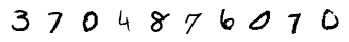

label: [3 7 0 4 8 7 6 0 7 0]
image data shape: (1, 28, 28)


In [10]:
## load MNIST training and test data
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

# Visualize 10 image samples in MNIST dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
# plot 10 sample images
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(np.transpose(images[i].numpy(),(1,2,0)).reshape(iml,-1),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()
print('label:',labels[:10].numpy())
print('image data shape:',images[0].numpy().shape)

In [0]:
## this is a simple convolutional network, with conv layers,
## batch normalization, etc etc
class ConvNet(nn.Module):                                                             
    def __init__(self, num_classes=10,droprate=.2):                                               
        super(ConvNet, self).__init__()                                               
        self.layer1 = nn.Sequential(                                                  
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), 
            nn.Dropout(droprate),                    
            nn.BatchNorm2d(16),                                                       
            nn.ReLU(),                                                                
            nn.MaxPool2d(kernel_size=2, stride=2))                                    
        self.layer2 = nn.Sequential(                                                  
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),  
            nn.Dropout(droprate),                  
            nn.BatchNorm2d(32),                                                       
            nn.ReLU(),                                                                
            nn.MaxPool2d(kernel_size=2, stride=2))                                    
        self.fc = nn.Linear(7*7*32, num_classes)                                      
                                                                                      
    def forward(self, x):                                                             
        out = self.layer1(x)                                                          
        out = self.layer2(out)                                                        
        out = out.reshape(out.size(0), -1)                                            
        out = self.fc(out)                                                            
        return out           

In [0]:
model = ConvNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() )

In [0]:
# Train the model
num_epochs = 3    
device = "cpu"                                                            
total_step = len(trainloader)                                                        
for epoch in range(num_epochs):                                                       
    for i, (images, labels) in enumerate(trainloader):                               
        images = images.to(device)                                                    
        labels = labels.to(device)                                                    
                                                                                      
        # Forward pass                                                                
        outputs = model(images)                                                       
        loss = criterion(outputs, labels)                                             
                                                                                      
        # Backward and optimize                                                       
        optimizer.zero_grad()                                                         
        loss.backward()                                                               
        optimizer.step()                                                              
                                                                                      
        if (i+1) % 100 == 0:                                                          
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'                        
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/3], Step [100/938], Loss: 0.0245
Epoch [1/3], Step [200/938], Loss: 0.0021
Epoch [1/3], Step [300/938], Loss: 0.0238
Epoch [1/3], Step [400/938], Loss: 0.1069
Epoch [1/3], Step [500/938], Loss: 0.0503
Epoch [1/3], Step [600/938], Loss: 0.0039
Epoch [1/3], Step [700/938], Loss: 0.0072
Epoch [1/3], Step [800/938], Loss: 0.0037
Epoch [1/3], Step [900/938], Loss: 0.0043


In [26]:
torch.cuda.is_available()

False